<a href="top"></a>
## Contents

* [Setup](#Setup)
* [References](#References)

## Setup


In [1]:
# Core dependencies
import numpy as np

from anguilla.optimizers.upmocma import UPMOCMA
from anguilla.fitness import benchmark

In [2]:
# Dependencies for the debug plot
from typing import Any

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.colors as colors

In [3]:
def contributions_plot(archive, fn=None, new_point=None, title="Population plot with contributions") -> Any:
    """Plot the contributions of individuals in the archive."""
    fig = plt.figure(figsize=(6, 4))
    axs = fig.subplots(1, 1)
    # We iterate through the archive to create a list of tuples with the desired data
    # Then, we unzip it into separate lists
    contribs, fitness = list(zip(*[(i.contribution, i.fitness) for i in archive]))
    contribs = np.array(contribs)
    fitness = np.array(fitness)
    if len(contribs) > 2:
        min_contrib = np.min(contribs[1:-1]) 
        max_contrib = np.max(contribs[1:-1])
    else:
        min_contrib = 0.0
        max_contrib = 0.0
    cmap = plt.cm.get_cmap("jet", len(contribs) - 2)
    for i, point in enumerate(fitness):
        if i == 0 or i == len(fitness) - 1:
            # Exterior points are plotted as stars (they have infinite contribution)
            axs.plot(fitness[i, 0], fitness[i, 1], marker="*", color="black", linestyle="")
        else:
            # Interior points are ploted as cyan crosses and their contributions as rectangles
            color = cmap(contribs[i] / max_contrib)
            rectangle = Rectangle(fitness[i],
                                  width=fitness[i+1, 0] - fitness[i, 0],
                                  height=fitness[i-1, 1] - fitness[i, 1],
                                  facecolor=color,
                                  alpha=0.5)
            axs.add_patch(rectangle)
            axs.plot(fitness[i, 0], fitness[i, 1], marker="+", color="cyan", linestyle="")
    if len(contribs) > 2:
        fig.colorbar(plt.cm.ScalarMappable(colors.Normalize(min_contrib, max_contrib), cmap=cmap), ax=axs)
    if fn is not None and fn.has_known_pareto_front:
        front = fn.pareto_front()
        axs.plot(front[0], front[1], color="red", label="True")
    if new_point is not None:
        axs.plot(new_point[0], new_point[1], color="green", label="New point", marker="P")
    axs.legend()
    axs.set_title(f"{title} (size {archive.size})")
    axs.set_xlabel("First objective")
    axs.set_ylabel("Second objective")
    fig.tight_layout()
    return fig

In [4]:
rng_base = np.random.default_rng()
#seed = rng_base.integers(1, 75458458, size=1)[0]
seed = 43724437
print("Seed: ", seed)

Seed:  43724437


We create an instance of the optimizer:

In [5]:
D = 10
rng = np.random.default_rng(seed)
fn = benchmark.MOQ("1|C", D, rng=rng)
initial_points = fn.random_points(D)
initial_fitness = fn(initial_points)
# Currently, just testing out the operation of a single instance
optimizer = UPMOCMA(initial_points, initial_fitness, rng=rng, max_evaluations=200000)

We can inspect the initial mutually non-dominated individuals that were inserted. Some of the initial points we generated at random were dominated by others, so they were not inserted. 

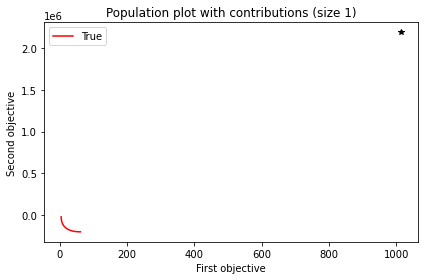

In [6]:
fig = contributions_plot(optimizer._population, fn)

In [7]:
point = optimizer.ask()
fitness = fn.evaluate_with_constraints(point)

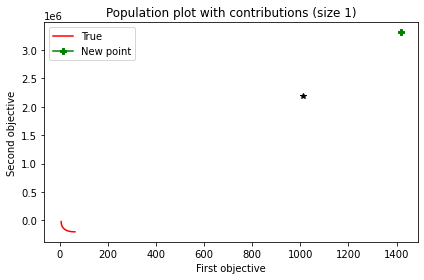

In [8]:
fig = contributions_plot(optimizer._population, fn=fn, new_point=fitness)

In [9]:
_ = optimizer.tell(fitness)

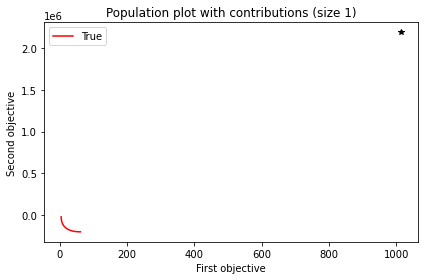

In [10]:
fig = contributions_plot(optimizer._population, fn=fn)

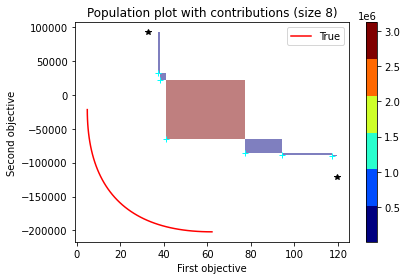

In [11]:
while not optimizer.stop.triggered:
    point = optimizer.ask()
    if fn.has_constraints:
        fitness, penalized_fitness = fn.evaluate_with_penalty(point)
        #fitness = fn.evaluate_with_constraints(point)
        optimizer.tell(penalized_fitness)
    else:
        fitness = fn(point)
        optimizer.tell(fitness)
fig = contributions_plot(optimizer._population, fn=fn)

## References

[1] O. Krause, T. Glasmachers, N. Hansen, and C. Igel. Unbounded Population MO-CMA-ES for the Bi-Objective BBOB Test Suite. In GECCO’16 - Companion of Proceedings of the 2016 Genetic and Evolutionary Computation Conference, 1177–1184. Denver, United States, July 2016. ACM. URL: https://hal.inria.fr/hal-01381653, doi:10.1145/2908961.2931699.